In [73]:
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [75]:
df_game_events = pd.read_csv('get data/clean_data/2018_clean.csv')
df_game_events

,game_id,period,period_time,team,event,coordinates_x,coordinates_y,secondary_type,empty_net,strength_name,rinkSide,shooter,goalie
0,2018020001,1.0,00:29,Montréal Canadiens,Shot,78.0,-19.0,Backhand,NaN,NaN,left,Artturi Lehkonen,Frederik Andersen
1,2018020001,1.0,00:49,Toronto Maple Leafs,Shot,-37.0,-10.0,Snap Shot,NaN,NaN,right,Morgan Rielly,Carey Price
2,2018020001,1.0,01:00,Montréal Canadiens,Shot,47.0,-23.0,Wrist Shot,NaN,NaN,left,Brendan Gallagher,Frederik Andersen
3,2018020001,1.0,03:54,Montréal Canadiens,Shot,53.0,14.0,Snap Shot,NaN,NaN,left,Brendan Gallagher,Frederik Andersen
4,2018020001,1.0,04:06,Montréal Canadiens,Shot,77.0,-2.0,Snap Shot,NaN,NaN,left,Mike Reilly,Frederik Andersen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85934,2018030417,3.0,15:22,St. Louis Blues,Goal,-77.0,7.0,Snap Shot,False,Even,right,Zach Sanford,Tuukka Rask
85935,2018030417,3.0,15:51,St. Louis Blues,Shot,-69.0,7.0,Snap Shot,NaN,NaN,right,Alexander Steen,Tuukka Rask
85936,2018030417,3.0,15:55,St. Louis Blues,Shot,-65.0,-4.0,Snap Shot,NaN,NaN,right,Ryan O'Reilly,Tuukka Rask
85937,2018030417,3.0,16:50,Boston Bruins,Shot,42.0,3.0,Wrist Shot,NaN,NaN,left,Marcus Johansson,Jordan Binnington


event,Shot,Goal,Total Shots,Success Rate,goal_percent
secondary_type,,,,,
Wrap-around,827,60,887,0.067644,0.727890
Deflected,1415,264,1679,0.157236,3.202717
Tip-In,3731,770,4501,0.171073,9.341259
Backhand,6178,825,7003,0.117807,10.008492
Snap Shot,10755,1213,11968,0.101354,14.715516
Slap Shot,11465,783,12248,0.063929,9.498969
Wrist Shot,43316,4328,47644,0.090840,52.505156


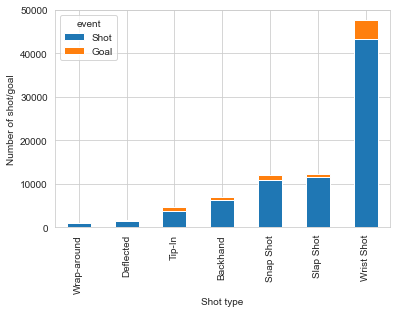

In [76]:
# pivot
df_shot_goal = df_game_events.groupby(['event','secondary_type']).size().reset_index().pivot(columns='event', index='secondary_type', values=0)
df_shot_goal = df_shot_goal.reindex(columns=['Shot','Goal'])
df_shot_goal.sort_values(['Shot','Goal'], ascending = [True, True], inplace=True)

# plot bar chart
df_shot_goal.plot(kind='bar', stacked=True)
plt.xlabel('Shot type')
plt.ylabel('Number of shot/goal')

# # analyse sucess rate of different shot types
df_total_shot_goal = df_shot_goal['Shot']+df_shot_goal['Goal']
df_shot_goal['Total Shots'] = df_total_shot_goal
df_shot_goal['Success Rate'] = df_shot_goal['Goal']/df_total_shot_goal
df_shot_goal['goal_percent'] = (df_shot_goal["Goal"]/df_shot_goal["Goal"].sum()) *100
df_shot_goal

In [77]:
def prep_data(path1, path2, path3):  
    df_2018 = pd.read_csv(path1)
    df_2019 = pd.read_csv(path2)
    df_2020 = pd.read_csv(path3)
    df_2018["season"] = "2018"
    df_2019["season"] = "2019"
    df_2020["season"] = "2020"
    df_all_season = pd.concat([df_2018,df_2019,df_2020]).reset_index(drop=True)
    df_all_season = df_all_season[df_all_season.rinkSide.notna() & df_all_season.coordinates_x.notna() & df_all_season.coordinates_y.notna()].reset_index(drop=True)
    df_all_season["offensive_goal_post_x"] = [-89 if i=="right" else 89 for i in df_all_season["rinkSide"]]
    df_all_season["offensive_goal_post_y"] = 0
    df_all_season["shot_distance"] = df_all_season.apply(lambda x: np.sqrt((x['offensive_goal_post_x']-x['coordinates_x'])**2 + (x['offensive_goal_post_y']-x['coordinates_y'])**2), axis=1)
    df_all_season['goal'] = np.where(df_all_season['event']=="Goal", True, False)
    return df_all_season

          game_id  period period_time                 team event  \
0      2018020001     1.0       00:29   Montréal Canadiens  Shot   
1      2018020001     1.0       00:49  Toronto Maple Leafs  Shot   
2      2018020001     1.0       01:00   Montréal Canadiens  Shot   
3      2018020001     1.0       03:54   Montréal Canadiens  Shot   
4      2018020001     1.0       04:06   Montréal Canadiens  Shot   
...           ...     ...         ...                  ...   ...   
83056  2018030417     3.0       15:22      St. Louis Blues  Goal   
83057  2018030417     3.0       15:51      St. Louis Blues  Shot   
83058  2018030417     3.0       15:55      St. Louis Blues  Shot   
83059  2018030417     3.0       16:50        Boston Bruins  Shot   
83060  2018030417     3.0       17:50        Boston Bruins  Goal   

       coordinates_x  coordinates_y secondary_type empty_net strength_name  \
0               78.0          -19.0       Backhand       NaN           NaN   
1              -37.0       

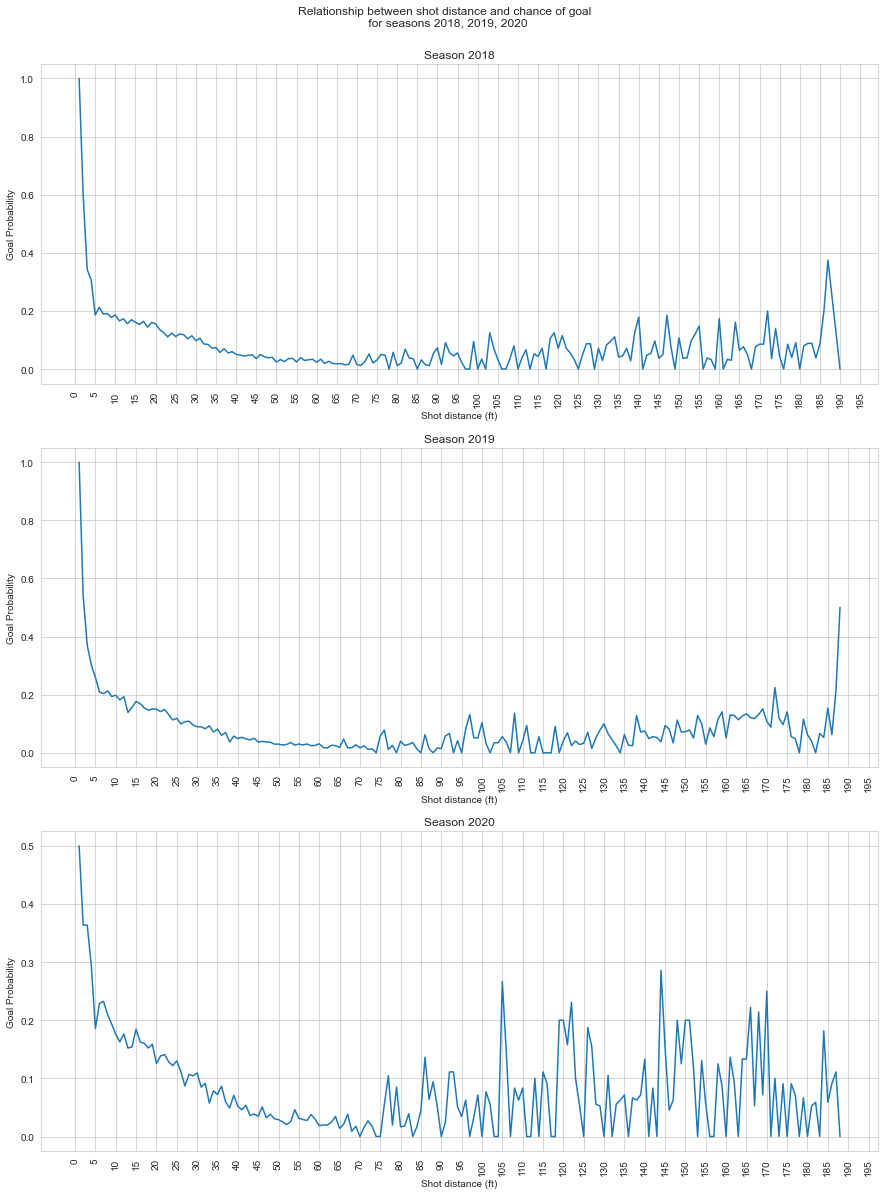

In [91]:
def distance_vs_goal(df_game_events):
    df_game_events['shot_distance'] = df_game_events['shot_distance'].round(0)
    fig = plt.figure(figsize=(15, 20))
    for season_idx, season in enumerate(['2018','2019','2020']):
        plt.subplot(3, 1, season_idx + 1)
        df_game_events_season = df_game_events[df_game_events['season'].astype(str)==season]
        print(df_game_events_season)
        df_game_events_season = df_game_events_season.groupby(['shot_distance'])['goal'].mean().to_frame().reset_index()
        ax = sns.lineplot(x='shot_distance', y='goal', data=df_game_events_season)
        plt.title(f'Season {season}')
        ax.set_axisbelow(True)
        plt.xticks(np.arange(0, 200, 5), rotation=90)
        plt.xlabel('Shot distance (ft)')
        plt.ylabel('Goal Probability')
        
    plt.suptitle('Relationship between shot distance and chance of goal \n for seasons 2018, 2019, 2020', size=12, y=0.92)
    
df_all_season = prep_data('get data/clean_data/2018_clean.csv', 'get data/clean_data/2019_clean.csv', 'get data/clean_data/2020_clean.csv')      
distance_vs_goal(df_all_season)


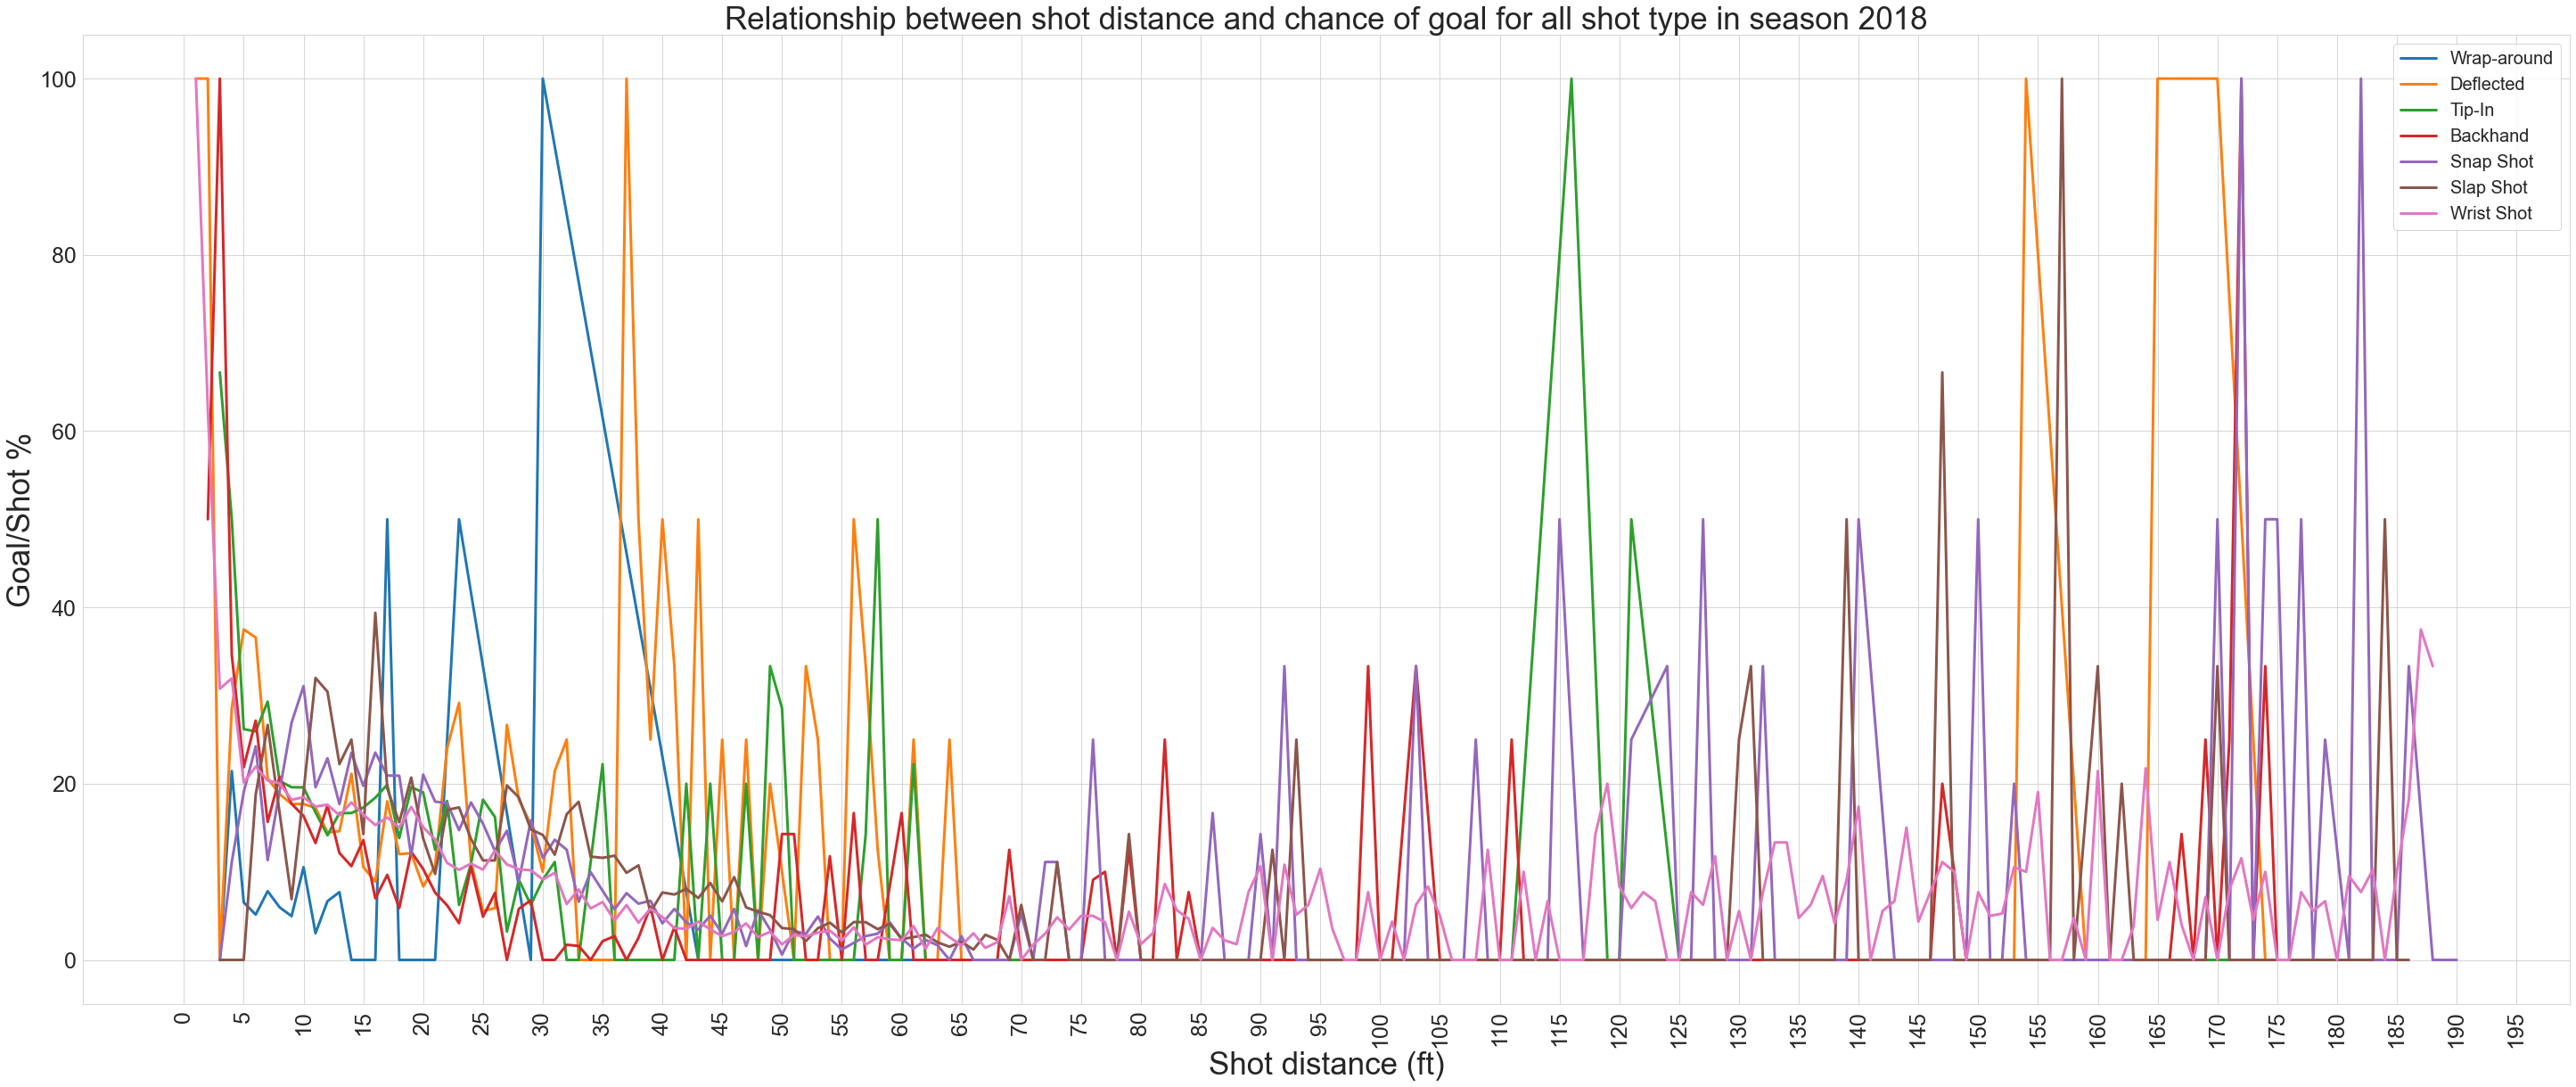

In [159]:
## 5 c
def distance_vs_goal_per_shot(df_game_events, df_shot_goal):
    df_game_events['shot_distance'] = df_game_events['shot_distance'].round(0)
    fig1 = plt.figure(figsize=(50, 20))
    df_game_events = df_game_events[df_game_events['season'].astype(str)=='2018']
#     print(df_game_events_season)
    for shot_type in (df_shot_goal.index):
        df_game_events_season = df_game_events[df_game_events['secondary_type']==shot_type]
        df_game_events_season = df_game_events_season.groupby(['shot_distance'])['goal'].mean().to_frame().reset_index()
        df_game_events_season['goal'] = df_game_events_season['goal'] * 100
        ax1 = sns.lineplot(x='shot_distance', y='goal', data=df_game_events_season, linewidth = 3, label=shot_type)
        
        plt.title('Relationship between shot distance and chance of goal for all shot type in season 2018', size=35)
        ax1.set_axisbelow(True)
    plt.xticks(np.arange(0, 200, 5), rotation=90, fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel('Shot distance (ft)', fontsize=35)
    plt.ylabel('Goal/Shot %', fontsize=35)
    plt.legend(loc='upper right', fontsize=20)
        
#     plt.suptitle('Relationship between shot distance and chance of goal for all shot type in season 2018', size=12, y=0.92)
    plt.show()

distance_vs_goal_per_shot(df_all_season, df_shot_goal)

In [ ]:
#We choose season as 2019-20
dff = season_plays_19_20
dff['distance_from_goal'] = np.where(dff['x_coord']<0, np.sqrt((-90-dff['x_coord'])**2 + (dff['y_coord'])**2), np.sqrt((90-dff['x_coord'])**2 + (dff['y_coord'])**2))


bins = pd.cut(dff['distance_from_goal'], 20)
# dff = dff.groupby(bins)['event_type_id'].apply(lambda x: ((x=='GOAL').size())/((x=='GOAL').size()+(x=='SHOT').size())).reset_index(name='Percentage_goal')

df_goal = dff.groupby([bins,'shot_type'])['event_type_id'].apply(lambda x: (x=='GOAL').sum())#.rename(column={'event_type_id':'n_goal'}, axis=1)[['n_goal']]
df_shot = dff.groupby([bins, 'shot_type'])['event_type_id'].apply(lambda x: (x=='SHOT').sum())#.rename(column={'event_type_id':'n_shot'}, axis =1)[['n_shot']]
df_goal_shot = pd.merge(df_goal, df_shot, how='inner',left_index=True, right_index=True).reset_index().rename(columns={'event_type_id_x':'n_goal', 'event_type_id_y':'n_shot', 'distance_from_goal':'binned_distance'})
df_goal_shot['Percentage_goal'] = df_goal_shot['n_goal']/(df_goal_shot['n_goal']+df_goal_shot['n_shot'])

df_goal_shot['binned_distance'] = df_goal_shot.binned_distance.apply(str)
df_final = df_goal_shot.pivot_table(values='Percentage_goal', index=['binned_distance'], columns=['shot_type']).reset_index()